# Simple Linear Model for Recognizing Hand-Written Digits with TensorFlow #

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/01_Simple_Linear_Model.ipynb

## Introduction ##

This notebook implements a simple linear model for recognizing hand-written digits with TensorFlow. I want to briefly introduce neurals network and TensorFlow in the context of a simple task in supervised learning. Once you become more familiar with neural networks and TensorFlow, I will show how to use neural networks approximate q-values in reinforcement learning.

Note that this is going to be a very brief introduction to neural networks and TensorFlow. We are going to have an entire class on these topics next semester.

## Imports ##

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

C:\Users\wocjan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.11.0'

## Load Data ##

In [3]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [5]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

### One-Hot Encoding ###

In [6]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [7]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

### Helper-function for plotting images ###

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct ###

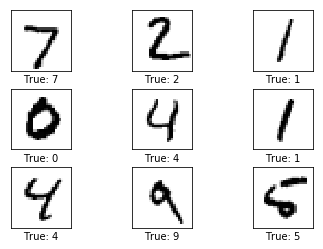

In [9]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph ##

### Placeholder variables ###

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [11]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [12]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Model variables ###

In [13]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [14]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model ###

In [15]:
logits = tf.matmul(x, weights) + biases

In [16]:
y_pred = tf.nn.softmax(logits)

In [17]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost function to be optimized ###

I changed it to v2 to avoid a warning. 
https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)

In [19]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method ###

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Performance measures ###

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run ##

### Create TensorFlow session ###

In [23]:
session = tf.Session()

### Initialize variables ###

In [24]:
session.run(tf.global_variables_initializer())

### Helper function to perform optimization iterations ###

In [25]:
batch_size = 100

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper functions to show performance ###

In [27]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [28]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [30]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper functions to plot the model weights ###

In [31]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Performance before any optimization ###

In [32]:
print_accuracy()

Accuracy on test-set: 9.8%


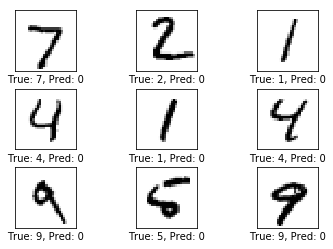

In [33]:
plot_example_errors()

## Performance after 1 optimization iteration ##

In [34]:
optimize(num_iterations=1)

In [35]:
print_accuracy()

Accuracy on test-set: 23.4%


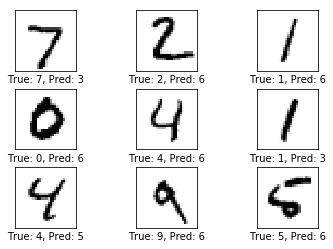

In [36]:
plot_example_errors()

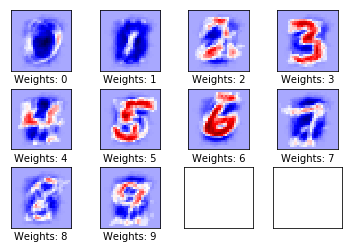

In [37]:
plot_weights()

## Performance after 10 optimization iterations ##

In [38]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [39]:
print_accuracy()

Accuracy on test-set: 78.4%


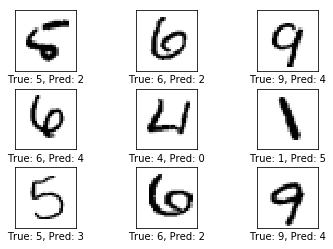

In [40]:
plot_example_errors()

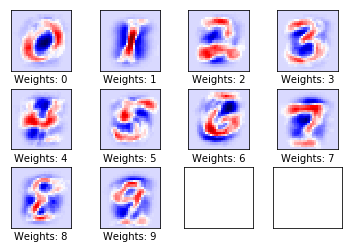

In [41]:
plot_weights()

### Performance after 1000 optimization iterations ###

In [42]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [43]:
print_accuracy()

Accuracy on test-set: 91.6%


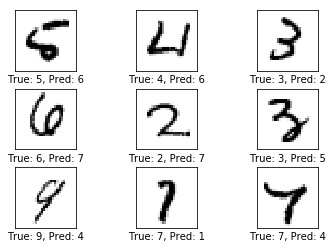

In [44]:
plot_example_errors()

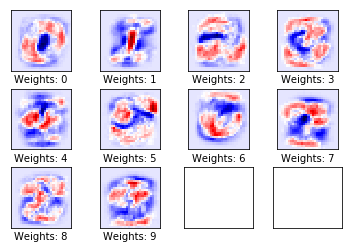

In [45]:
plot_weights()

[[ 960    0    2    1    0    6    7    1    3    0]
 [   0 1121    2    2    0    2    3    1    4    0]
 [   7   18  913    7   15    3   11   15   37    6]
 [   3    2   27  872    0   54    2   15   27    8]
 [   1    7    2    2  909    0   10    3    7   41]
 [  11    6    4   14    9  790   11    8   34    5]
 [  12    3    4    2   11   18  900    3    5    0]
 [   4   19   23    6    6    0    0  940    1   29]
 [   7   23    6   15    8   30   10   10  859    6]
 [  11    9    2    6   34   10    0   28   13  896]]


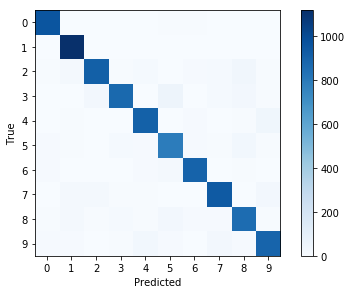

In [46]:
print_confusion_matrix()

In [ ]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()